# <!-- TITLE --> [SYNOP3] - 12h predictions
<!-- DESC --> Episode 3: Attempt to predict in a more longer term 
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Prediction at 12:00
 - Understand the principle of using recurrent neurons... and the limitations of our example !


SYNOP meteorological data, available at: https://public.opendatasoft.com

## What we're going to do :

 - Read the data
 - Make a reccurent prediction

## Step 1 - Import and init
### 1.1 - Python

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload


run_dir = './run/SYNOP'
datasets_dir = 'fidle-datasets'

### 1.2 - Parameters

In [2]:
# ---- About dataset (no need to change)
#
dataset_dir      = './data'                  # Enhanced dataset is very small, so ./data in a good choice :-)
dataset_filename = 'synop-LYS.csv'
schema_filename  = 'synop.json'
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)

# ---- About training
#
iterations       = 4        # number of iterations for prediction (1 iteration = 3h)

scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
sequence_len     = 16       # Sequence len

## Step 2 - Read and prepare dataset
**Note** : The `scale` and `train_prop` parameters must be identical to those used during training (SYNOP2)... ;-)

In [3]:
# ---- Read dataset

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')

# ---- Scaling

df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))

# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]

# ---- Normalize, and convert to numpy array
mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = np.array( (dataset_train - mean) / std )
dataset_test  = np.array( (dataset_test  - mean) / std )

print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)


Dataset       :  (29165, 14)
Train dataset :  (23332, 12)
Test  dataset :  (5833, 12)


## Step 3 - Predict

### 3.1 - Load model

In [4]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/best_model.h5')

### 3.2 Make a 12h prediction

In [5]:
def plot_multivariate_serie(sequence, labels=None, predictions=None, only_features=None,
                            columns=3, width=5,height=4,wspace=0.3,hspace=0.2,ms=6,lw=1,
                            time_dt=1, hide_ticks=False):
    
    sequence_len = len(sequence)
    features_len = sequence.shape[1]
    if only_features is None : only_features=range(features_len)
    if labels is None        : labels=range(features_len)
    
    t  = np.arange(sequence_len)    
    if predictions is None:
        dt = 0
    else:
        dt = len(predictions)
        sequence_with_pred = sequence.copy()
        sequence_with_pred[-dt:]=predictions

    rows = math.ceil(features_len/columns)
    fig  = plt.figure(figsize=(columns*width, rows*height))
    fig.subplots_adjust(wspace=0.3,hspace=0.2)
    n=1
    for i in only_features:
        ax=fig.add_subplot(rows, columns, n)
        
        # ---- Real sequence without prediction
        #
        ax.plot( t[:-dt],sequence[:-dt,i], 'o',  markersize=ms, color='C0', zorder=2)
        ax.plot( t,sequence[:,i],          '-',  linewidth=lw,  color='C0', label=labels[i],zorder=1)

        # ---- What we expect
        #
        ax.plot(t[-dt:], sequence[-dt:,i], 'o', markeredgecolor='C0',markerfacecolor='white',ms=6)
        
        if predictions is not None:
            ax.plot(t[-dt-1:], sequence_with_pred[-dt-1:,i], '--',  lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=1)
            ax.plot(t[-dt:],   predictions[:,i],             'o',   lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=2)

        if hide_ticks:
            ax.set_yticks([])
            ax.set_xticks([])
        
        ax.legend(loc="upper left")
        n+=1    
    plt.show()

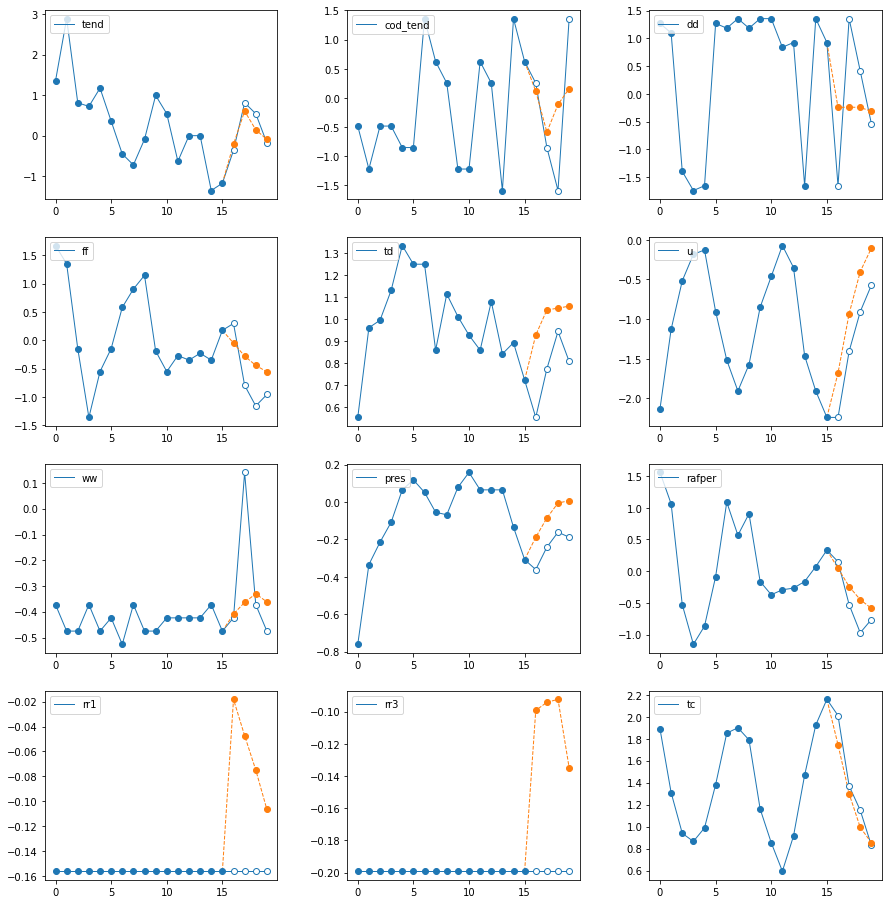

In [8]:
# ---- Initial sequence

s=random.randint(0,len(dataset_test)-sequence_len-iterations)

sequence_pred = dataset_test[s:s+sequence_len].copy()
sequence_true = dataset_test[s:s+sequence_len+iterations].copy()

# ---- Iterate on 4 predictions

sequence_pred=list(sequence_pred)

for i in range(iterations):
    sequence=sequence_pred[-sequence_len:]
    pred = loaded_model.predict( np.array([sequence]) )
    sequence_pred.append(pred[0])

# ---- Extract the predictions    

pred=np.array(sequence_pred[-iterations:])
       
# ---- Show result

plot_multivariate_serie(sequence_true, predictions=pred, labels=features)


### 3.3 Full prediction
#### Some cool functions that do the job

In [9]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


def get_prediction(dataset, model, iterations=4,sequence_len=16):

    # ---- Initial sequence

    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    # ---- Iterate

    sequence_pred=list(sequence_pred)

    for i in range(iterations):
        sequence=sequence_pred[-sequence_len:]
        pred = model.predict( np.array([sequence]) )
        sequence_pred.append(pred[0])

    # ---- Extract the predictions    

    pred=np.array(sequence_pred[-iterations:])

    # ---- De-normalization

    sequence_true = denormalize(mean,std, sequence_true)
    pred          = denormalize(mean,std, pred)

    return sequence_true,pred

#### And the result is...

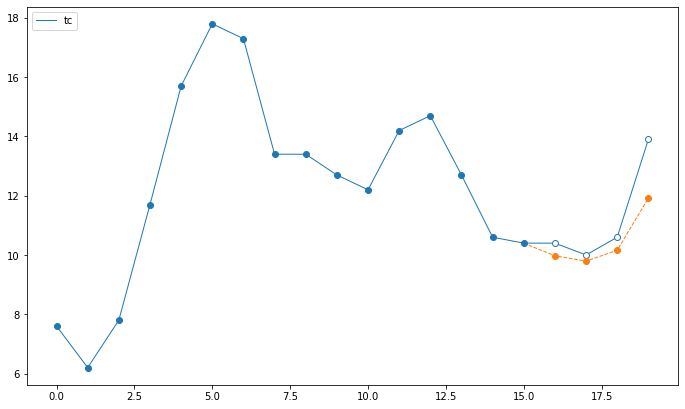

In [10]:
sequence_true, pred = get_prediction(dataset_test, loaded_model,iterations=4)

feat=11

plot_multivariate_serie(sequence_true, predictions=pred, labels=features,
                            only_features=[feat],width=14, height=8)